In [1]:
import sys
import numpy as np
from functools import reduce
import sounddevice as sd

from pam import SoundCommunication

In [2]:
import reedsolo as rs

In [3]:
cod = rs.RSCodec(80)

In [4]:
# sampling rate
FS = 44100

In [5]:
def pad(W, padding=0.5):
    return np.hstack((np.zeros(int(FS*padding)), W, np.zeros(int(FS*padding))))

In [7]:
def encode_rs(text):

    num_parity = 80
    assert len(text) < 255 - num_parity
    msg_bytes = text.encode('ascii')
    
    msg_bytes = b'\x00' * (255 - num_parity - len(msg_bytes)) + msg_bytes

    codec = rs.RSCodec(num_parity)
    return codec.encode(msg_bytes)

In [6]:
f = open('text.txt')
text = f.read()

In [8]:
def decode_rs(msg_bytes_rs):
    num_parity = 80

    codec = rs.RSCodec(num_parity)
    msg_bytes = codec.decode(msg_bytes_rs)
    while msg_bytes[0] == 0:
        msg_bytes = msg_bytes[1:]
    return msg_bytes

In [9]:
comm = SoundCommunication(FS, 200, 1000, 2000, msgSymLen=255*8)
from testing import Tester
t = Tester(comm)

In [17]:
r = encode_rs(text)
S = comm.send(r)
W = t.addBandpassNoise(S, 2.3, 0)
rw = comm.decode(W)
t.diff(r, rw)

('00000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000000101010001101000011001010010000001110011011101000111010101100100011110010010000001101111011001100010000001000101011011100110011101101100011010010111001101101000001000000110110001101001011101000110010101110010011000010111010001110101011100100110010X0010000001101001011011100010000X01110100011010000110010100100000011001010110000101110010011011000111100100100000011101000111011101100101011011100111010001X11001001011010110011001101001011100100111001101110100001000000110001101100101011011100111010001110101011100X001111001001000000110100101110011001000000110X0000110111101110011011101X000100000000010100111010001X01111001000000110000101101110001000000110010101111000011010000110100101101100011000010111001001100001011101000110100101101110011001110010000001110010011000010110111001100111011001010010000001101111011001100010000001100011011100100110100101110100011010010110001101100001011011

In [18]:
decode_rs(rw)

bytearray(b'The study of English literature in the early twenty-first century is host \nto an exhilarating range of critical approaches, theories and historical perspectives.')

In [58]:
import matplotlib.pyplot as plt


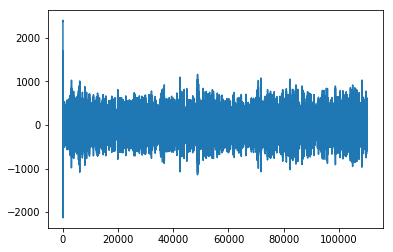

In [62]:
plt.plot(np.correlate(W[:3*comm.FS], comm.corr_signal()))
plt.show()